In [43]:
pip install tensorflow_addons

     -------------------------------------- 719.8/719.8 kB 3.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy import stats
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
from sklearn.model_selection import train_test_split

In [3]:
def load_data():
    # loading and preprocessing dataset 
    data = pd.read_csv("../dataset/annotations/annotations.csv")
    data = data[['id','image','score']]
        
    images = []
    for i in range(0,len(data)):
        filepath = data['image'][i]
        image = cv2.imread('../dataset/images/{0}'.format(filepath),cv2.IMREAD_COLOR)

        if image is not None:
            new_dimensions = (224, 224)
            resized_image = cv2.resize(image, new_dimensions, interpolation=cv2.INTER_AREA)
            images.append(resized_image)

    return np.array(images), np.array(data['score'])

In [4]:
images, ratings = load_data()
images = images / 255.0  # normalize images

print(images.shape)

X_train, X_test, y_train, y_test = train_test_split(images, ratings, test_size=0.2, random_state=42)

print(y_train)


(1985, 224, 224, 3)
[64. 79. 39. ... 71. 54. 57.]


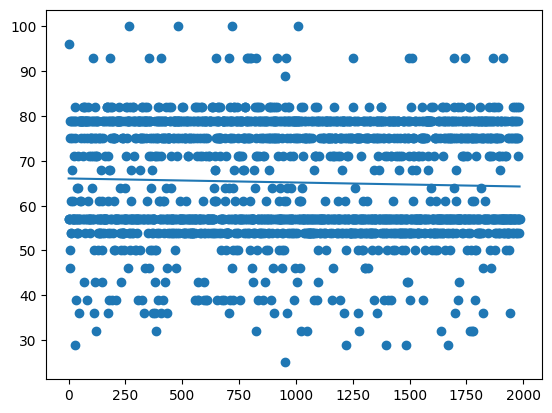

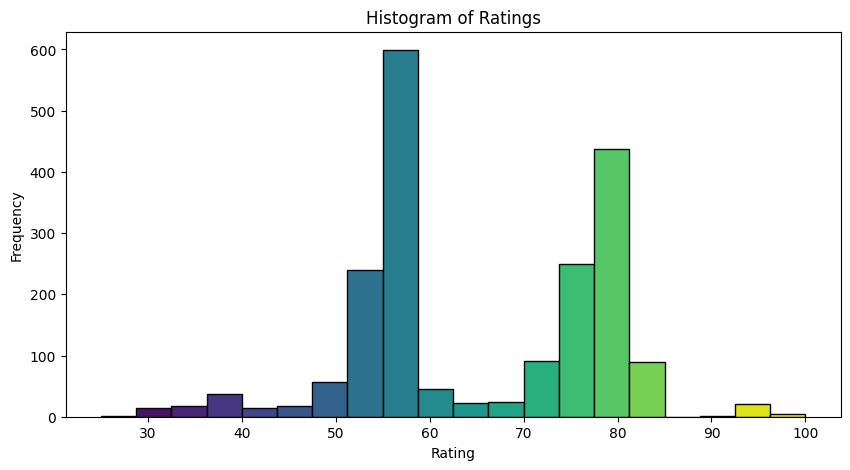

In [16]:
slope, intercept, r, p, std_err = stats.linregress(range(len(ratings)), ratings)

def myfunc(x):
  return slope * x + intercept

mymodel = list(map(myfunc, range(len(ratings))))

plt.scatter(range(len(ratings)), ratings)
plt.plot(range(len(ratings)), mymodel)
plt.show()


n_bins = 20
colors = plt.cm.viridis(np.linspace(0, 1, n_bins))

plt.figure(figsize=(10, 5))
n, bins, patches = plt.hist(ratings, bins=n_bins, edgecolor='black')
for i in range(n_bins):
    patches[i].set_facecolor(colors[i])

plt.title('Histogram of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()


In [6]:
base_model = ResNet50(
    weights='imagenet', 
    include_top=False, 
    input_shape=(224,224,3)
    )

# Add custom top layers for regression
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='linear')(x)  # Output layer for regression

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae',tf.keras.metrics.R2Score()])
history = model.fit(X_train, y_train, epochs=20, validation_split=0.2, batch_size=32)





Epoch 1/20


40/40 [==============================] - 50s 1s/step - loss: 891.2511 - mae: 23.1721 - r2_score: -4.6767 - val_loss: 193.9130 - val_mae: 11.0696 - val_r2_score: -0.2148
Epoch 2/20
40/40 [==============================] - 46s 1s/step - loss: 194.6368 - mae: 11.6829 - r2_score: -0.2397 - val_loss: 172.2269 - val_mae: 11.3099 - val_r2_score: -0.0789
Epoch 3/20
40/40 [==============================] - 46s 1s/step - loss: 187.1099 - mae: 11.7706 - r2_score: -0.1918 - val_loss: 168.1430 - val_mae: 11.4084 - val_r2_score: -0.0534
Epoch 4/20
40/40 [==============================] - 46s 1s/step - loss: 183.0054 - mae: 11.7597 - r2_score: -0.1656 - val_loss: 167.3762 - val_mae: 11.2446 - val_r2_score: -0.0486
Epoch 5/20
40/40 [==============================] - 45s 1s/step - loss: 178.1217 - mae: 11.5897 - r2_score: -0.1345 - val_loss: 164.8167 - val_mae: 11.3074 - val_r2_score: -0.0325
Epoch 6/20
40/40 [==============================] - 45s 1s/step - loss: 177.6076 - mae: 11.4390

In [9]:
test_loss, test_mae, test_r2 = model.evaluate(X_test, y_test)
print(f'Test MAE: {test_mae}')
print(f'Test loss: {test_loss}')
print(f'Test r2: {test_r2}')

13/13 [==============================] - 12s 882ms/step - loss: 162.8159 - mae: 11.5125 - r2_score: 0.0060
Test MAE: 11.51254653930664
Test loss: 162.81591796875
Test r2: 0.0059795379638671875


In [12]:
def plot_metrics(history, metrics):
    """
    Plots the specified metrics from the training history.
    
    Parameters:
    - history: The history object returned by model.fit()
    - metrics: A list of metric names to plot
    """
    epochs_range = range(1, len(history.history['loss']) + 1)
    
    num_metrics = len(metrics)
    plt.figure(figsize=(5 * num_metrics, 5))

    for i, metric in enumerate(metrics):
        plt.subplot(1, num_metrics, i + 1)
        plt.plot(epochs_range, history.history[metric], label=f'Training {metric}')
        plt.plot(epochs_range, history.history[f'val_{metric}'], label=f'Validation {metric}')
        plt.xlabel('Epochs')
        plt.ylabel(metric)
        plt.title(metric.capitalize())
        plt.legend()

    plt.tight_layout()
    plt.show()

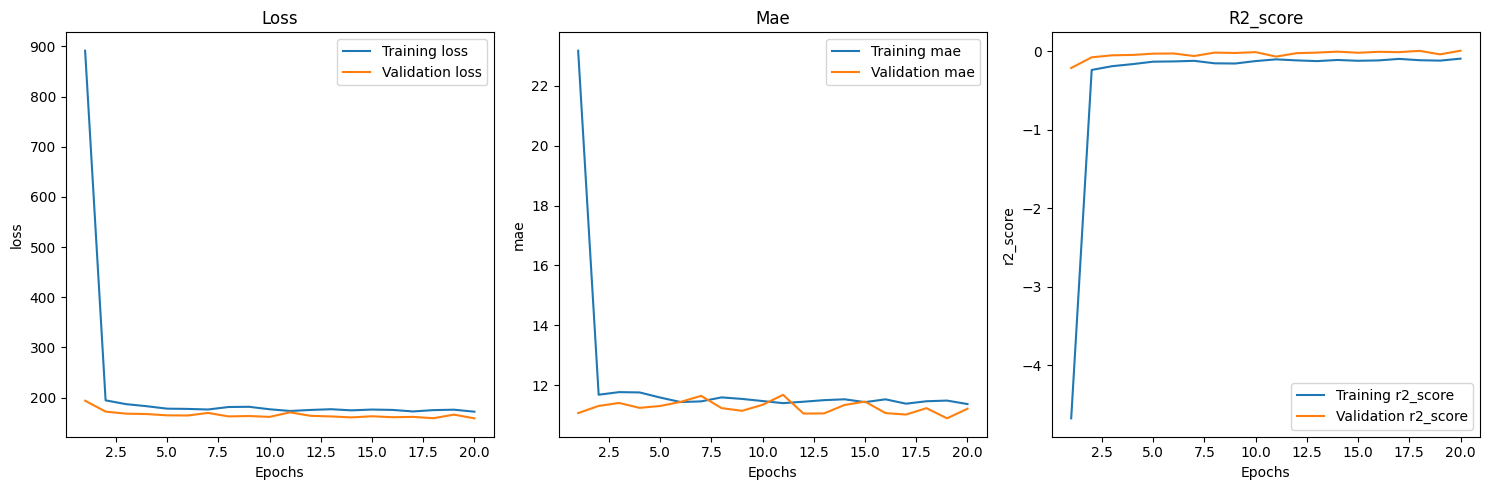

In [13]:
plot_metrics(history, ['loss', 'mae', 'r2_score'])

In [11]:
for layer in base_model.layers[-10:]:
    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='mean_squared_error', metrics=['mae',tf.keras.metrics.R2Score()])
history_fine = model.fit(X_train, y_train, epochs=10, validation_split=0.2, batch_size=32)

Epoch 1/10
40/40 [==============================] - 55s 1s/step - loss: 211.3151 - mae: 12.1687 - r2_score: -0.3459 - val_loss: 165.6369 - val_mae: 11.5428 - val_r2_score: -0.0377
Epoch 2/10
40/40 [==============================] - 49s 1s/step - loss: 165.4459 - mae: 11.0230 - r2_score: -0.0538 - val_loss: 161.8657 - val_mae: 11.4069 - val_r2_score: -0.0140
Epoch 3/10
40/40 [==============================] - 49s 1s/step - loss: 159.6017 - mae: 10.8176 - r2_score: -0.0166 - val_loss: 164.6465 - val_mae: 11.4965 - val_r2_score: -0.0315
Epoch 4/10
40/40 [==============================] - 52s 1s/step - loss: 155.7369 - mae: 10.5294 - r2_score: 0.0081 - val_loss: 191.9437 - val_mae: 12.0882 - val_r2_score: -0.2025
Epoch 5/10
40/40 [==============================] - 49s 1s/step - loss: 147.0755 - mae: 10.3208 - r2_score: 0.0632 - val_loss: 203.5107 - val_mae: 12.3167 - val_r2_score: -0.2749
Epoch 6/10
40/40 [==============================] - 47s 1s/step - loss: 143.2689 - mae: 10.2218 - r2_s

In [14]:
test_loss, test_mae, test_r2 = model.evaluate(X_test, y_test)
print(f'Test MAE: {test_mae}')
print(f'Test loss: {test_loss}')
print(f'Test r2: {test_r2}')

13/13 [==============================] - 11s 861ms/step - loss: 178.4730 - mae: 11.4068 - r2_score: -0.0896
Test MAE: 11.406819343566895
Test loss: 178.47303771972656
Test r2: -0.08960998058319092


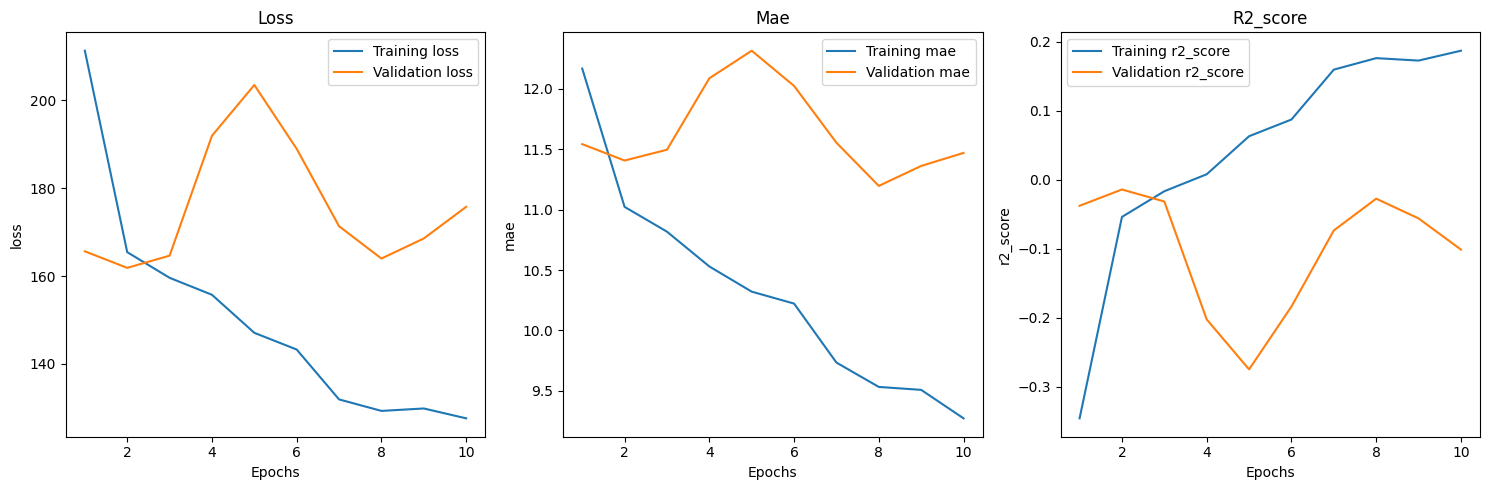

In [15]:
plot_metrics(history_fine, ['loss', 'mae', 'r2_score'])

In [68]:
#model.save("BetterSEOModel.keras")
model.save("BetterSEOModel.h5")

In [69]:
new_model = tf.keras.models.load_model('BetterSEOModel.h5')

In [70]:
# Predict rating for a new screenshot
def predict_rating(screenshot):
    new_dimensions = (224,224)
    resized_image = cv2.resize(screenshot, new_dimensions, interpolation=cv2.INTER_AREA)
    screenshot = resized_image / 255.0
    screenshot = np.expand_dims(screenshot, axis=0)  
    predicted_rating = new_model.predict(screenshot)
    return predicted_rating[0][0]

# Load Screenshot and make prediction
new_screenshot = cv2.imread('../dataset/images/{0}'.format('animemojo.png'),cv2.IMREAD_COLOR)
predicted_rating = predict_rating(new_screenshot)
print(f'Predicted Rating: {predicted_rating}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 814ms/step
Predicted Rating: 72.47376251220703
